# Support Vector Machine 구현하기

이 노트북에서는 Support Vector Machine(SVM)의 기본 개념을 이해하고 간단한 버전을 직접 구현해보겠습니다.

## 목차
1. 기본 개념 이해하기
2. 데이터 준비
3. 간단한 선형 SVM 구현
4. 결과 시각화
5. 개선 방향 논의

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Apple SD Gothic Neo'
plt.rcParams['axes.unicode_minus'] = False

from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## 1. 기본 개념 이해하기

---

### 🔹 결정 경계 (Decision Boundary)

- 두 클래스를 구분하는 선(2D) 또는 초평면(고차원)이다.
- **SVM이 학습하는 것은 이 결정 경계이다.**

\[
$\mathbf{w}^\top \mathbf{x} + b = 0$
\]


---

### 🔹 마진 (Margin)

- 결정 경계와 가장 가까운 데이터 포인트(서포트 벡터) 사이의 거리이다.
- SVM은 이 마진을 최대화하려고 학습한다.

\[
$\text{Margin} = \frac{2}{\|\mathbf{w}\|}$
\]

- 마진이 넓을수록 모델이 더 일반화되기 쉽다.

---

### 🔹 서포트 벡터 (Support Vectors)

- 결정 경계에 가장 가까이 위치한 데이터 포인트들이다.
- 이 포인트들이 SVM의 결정 경계를 직접 정의한다.
- 나머지 데이터는 경계에 영향을 거의 주지 않는다.

---

In [71]:
import numpy as np 

# 랜덤한 2D 데이터 생성
np.random.seed(42)

# np.random.randn(row, col) 표준정규분포(평균 0, 표준편차 1)로 랜덤한 데이터 생성 (row x col 크기의 행렬)
X_pos = np.round(np.random.randn(5, 2),0) + np.array([2, 2])   # 클래스 +1
X_neg = np.round(np.random.randn(5, 2),0) + np.array([-2, -2]) # 클래스 -1

# np.vstack() 두 개의 행렬을 위아래로 붙여서 하나의 행렬로 만듦
# np.hstack() 두 개의 행렬을 옆으로 붙여서 하나의 행렬로 만듦
X = np.vstack((X_pos, X_neg))
y = np.array([1]*5 + [-1]*5)

# 가중치(w)와 절편(b) 직접 설정 (예시)
w = np.array([1, 1])
b = 0

In [75]:
# 결정함수: w^T x + b = 0
# 이 결과 값이 +1이면 양성, -1이면 음성 클래스에 속함
def decision_function(X, w, b):
    # return X @ w + b
    return X[:, 0] * w[0] + X[:, 1] * w[1] + b

# 결정함수 적용
decision_function(X, w, b)

array([ 4.,  7.,  4.,  7.,  5., -4., -6., -7., -5., -6.])

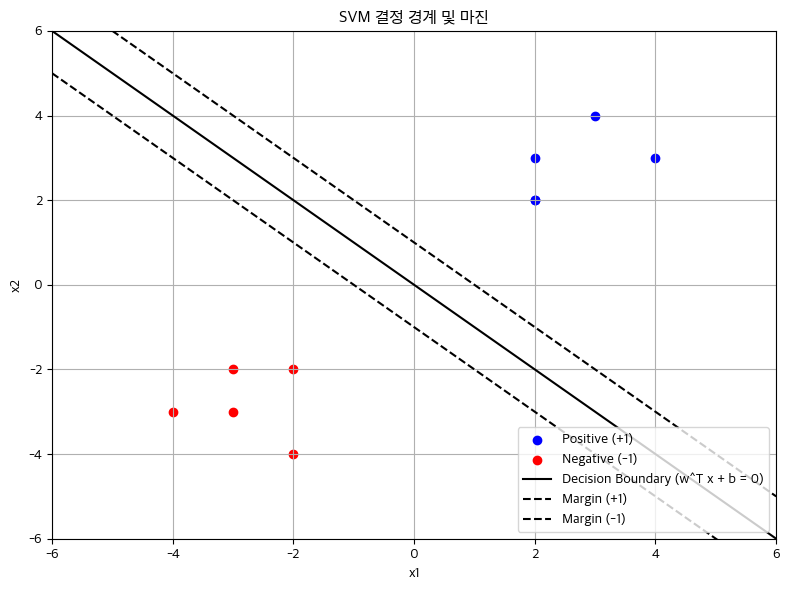

In [73]:
# 플롯
plt.figure(figsize=(8,6))

# 데이터 포인트 그리기
plt.scatter(X_pos[:,0], X_pos[:,1], color='b', label='Positive (+1)')
plt.scatter(X_neg[:,0], X_neg[:,1], color='r', label='Negative (-1)')

# 결정 경계 그리기
# w^T x + b = 0 => x2 = -(w1/w2) * x1 - (b/w2)
x1 = np.linspace(-6, 6, 100)
x2 = -(w[0]/w[1])*x1 - b/w[1]
plt.plot(x1, x2, 'k-', label='Decision Boundary (w^T x + b = 0)')

# 마진 경계 (w^T x + b = ±1)
x2_margin_pos = -(w[0]/w[1])*x1 - (b-1)/w[1]
x2_margin_neg = -(w[0]/w[1])*x1 - (b+1)/w[1]
plt.plot(x1, x2_margin_pos, 'k--', label='Margin (+1)')
plt.plot(x1, x2_margin_neg, 'k--', label='Margin (-1)')

# 스타일링
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('SVM 결정 경계 및 마진')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## 2. 데이터: Breast Cancer 

- target = 0 → 악성 (Malignant), target = 1 → 양성 (Benign)

In [21]:
# def generate_data(n_samples=100):
#     """간단한 이진 분류 데이터셋 생성"""
#     X, y = make_blobs(n_samples=n_samples, centers=2, random_state=42)
#     # 레이블을 1과 -1로 변환 (SVM 규칙)
#     y = np.where(y == 0, -1, 1)
#     return X, y

# # 데이터 생성
# X, y = generate_data()

# # 데이터 시각화
# plt.figure(figsize=(8, 6))
# plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='클래스 1')
# plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], label='클래스 -1')
# plt.title('생성된 데이터')
# plt.legend()
# plt.show()

In [22]:
# 데이터 로드
data = load_breast_cancer()
X, y = data.data, data.target

print(f"Feature shape: {X.shape}")
print(f"Class distribution: {sum(y==0)} malignant, {sum(y==1)} benign")



Feature shape: (569, 30)
Class distribution: 212 malignant, 357 benign


In [29]:
data.feature_names = [i.replace(' ', '_') for i in data.feature_names]

df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y
df.head()


,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


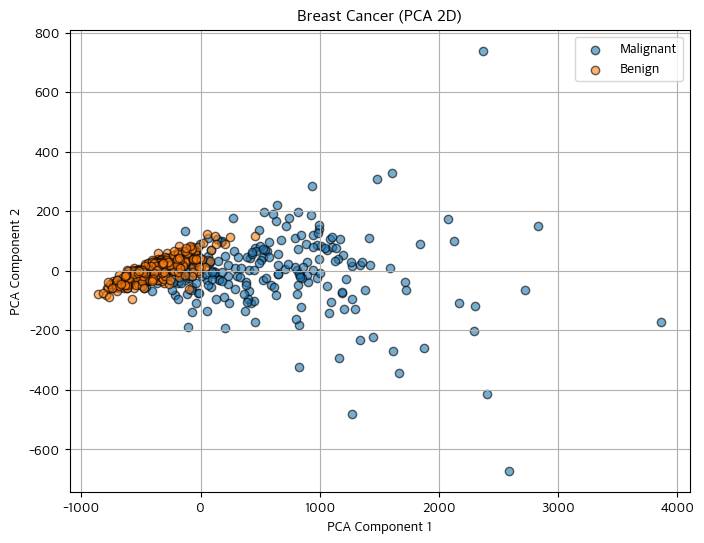

In [30]:
# PCA로 2차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 시각화
plt.figure(figsize=(8,6))
plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], label='Malignant', alpha=0.6, edgecolors='k')
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], label='Benign', alpha=0.6, edgecolors='k')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Breast Cancer (PCA 2D)')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# 결정 경계 시각화 함수
def plot_decision_boundary(X, y, model):
    plt.figure(figsize=(10, 8))
    
    # 데이터 포인트 그리기
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='클래스 1')
    plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], label='클래스 -1')
    
    # 결정 경계 그리기
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    
    plt.title('SVM 결정 경계')
    plt.legend()
    plt.show()

## 3. 간단한 선형 SVM 구현 with Primal SVM + Hinge Loss + L2
- SVM은 $\frac{1}{2}\|\mathbf{w}\|^2 + C \sum \max(0, 1 - y_i(\mathbf{w}^\top \mathbf{x}_i + b))$를 최소화한다.
- $y_i(\mathbf{w}^\top \mathbf{x}_i + b) \geq 1$이면 $\nabla_{\mathbf{w}} = \lambda \mathbf{w}$, 그렇지 않으면 $\nabla_{\mathbf{w}} = \lambda \mathbf{w} - y_i \mathbf{x}_i$이다.
- 경사하강법으로 $\mathbf{w}, b$를 반복 업데이트하여 최대 마진 분류기를 학습한다.


In [8]:
class SimpleSVM:
    def __init__(self, learning_rate=0.01, lambda_param=0.01, n_iters=1000):
        # 학습률: 각 반복에서 파라미터를 얼마나 업데이트할지 결정
        self.lr = learning_rate
        # 정규화 파라미터: 과적합을 방지하기 위한 L2 정규화 강도 (C = 1/lambda)
        self.lambda_param = lambda_param
        # 반복 횟수: 경사하강법을 수행할 횟수
        self.n_iters = n_iters
        # 가중치 벡터: 결정 경계의 방향을 결정
        self.w = None
        # 편향: 결정 경계의 위치를 조정
        self.b = None

    def fit(self, X, y):
        # 데이터의 샘플 수와 특성 수
        n_samples, n_features = X.shape
        # 레이블을 {-1, 1}로 변환 (SVM의 표준 형식)
        y_ = np.where(y <= 0, -1, 1)

        # 가중치와 편향 초기화
        self.w = np.zeros(n_features)
        self.b = 0

        # 경사하강법으로 파라미터 학습
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                
                # 마진 계산: y_i(w^T x_i + b)
                condition = y_[idx] * (np.dot(x_i, self.w) + self.b)

                # 마진이 1보다 크거나 같은 경우 (정확히 분류된 경우)
                if condition >= 1:
                    # L2 정규화만 적용
                    dw = self.lambda_param * self.w
                    db = 0
                # 마진이 1보다 작은 경우 (잘못 분류된 경우)
                else:
                    # L2 정규화 + hinge loss의 그래디언트
                    dw = self.lambda_param * self.w - y_[idx] * x_i
                    db = -y_[idx]

                # 파라미터 업데이트
                self.w -= self.lr * dw
                self.b -= self.lr * db

    def predict(self, X):
        # 선형 함수 계산: w^T x + b
        linear_output = np.dot(X, self.w) + self.b
        # 부호 함수로 클래스 예측 (-1 또는 1)
        return np.sign(linear_output)

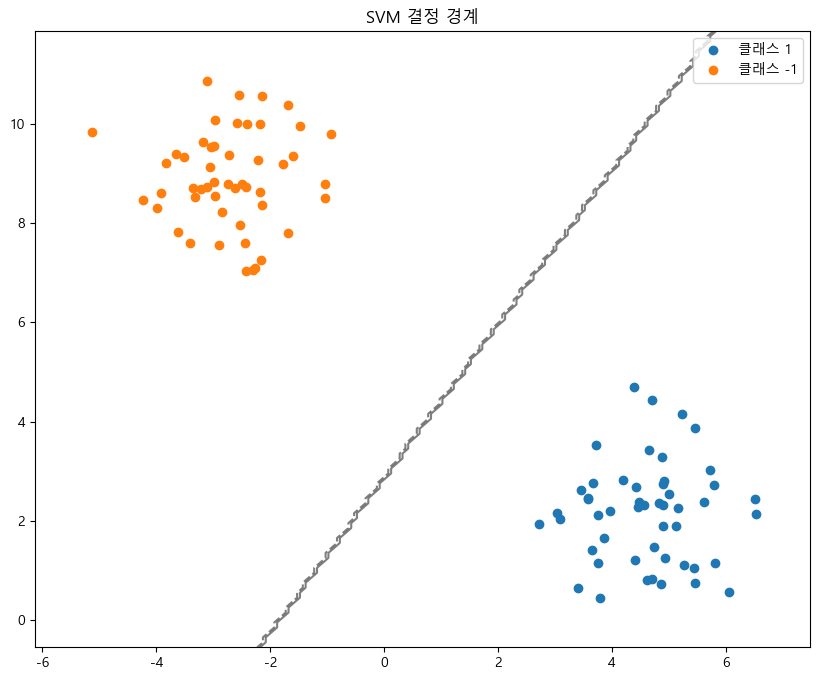

In [9]:
# 모델 학습
svm = SimpleSVM()
svm.fit(X, y)

# 결과 시각화
plot_decision_boundary(X, y, svm)

## 3-1. 간단한 선형 SVM 구현 with GD

기본적인 선형 SVM은 다음과 같은 결정 함수를 사용합니다:

f(x) = wx + b

여기서:
- w: 가중치 벡터
- x: 입력 데이터
- b: 편향

우리는 간단한 경사 하강법을 사용하여 이 파라미터들을 학습할 것입니다.

In [10]:
class SimpleSVM:
    def __init__(self, learning_rate=0.01, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # 가중치와 편향 초기화
        self.w = np.zeros(n_features)
        self.b = 0
        
        # 경사 하강법
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w) + self.b) >= 1
                
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y[idx]))
                    self.b -= self.lr * y[idx]
    
    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

## 4. 모델 학습 및 결과 시각화

이제 구현한 SVM 모델을 학습하고 결과를 시각화해보겠습니다.

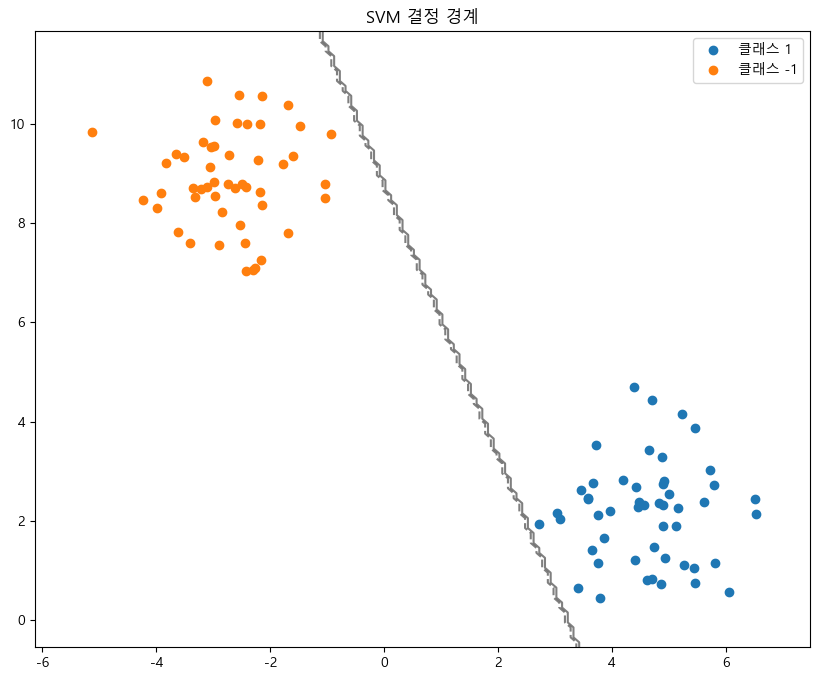

In [11]:
# 모델 학습
svm = SimpleSVM()
svm.fit(X, y)

# 결과 시각화
plot_decision_boundary(X, y, svm)

## 5. 개선 방향

지금까지 구현한 SVM은 매우 기본적인 버전입니다. 다음과 같은 방향으로 개선할 수 있습니다:

1. 커널 트릭 추가하기 (비선형 분류)
2. SMO(Sequential Minimal Optimization) 알고리즘 적용
3. 소프트 마진 구현
4. 다중 클래스 분류 지원

이러한 개선사항들은 차근차근 학습하면서 구현해볼 수 있습니다.